link to Kaggle:
https://www.kaggle.com/datasets/wcukierski/enron-email-dataset/data

git link:
https://github.com/MaorEl/cyber-ai

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
enron_df = pd.read_pickle('enron_students.pkl')
enron_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Date            517401 non-null  object
 1   From            517401 non-null  object
 2   To              495554 non-null  object
 3   X-To            517372 non-null  object
 4   X-From          517372 non-null  object
 5   X-cc            517372 non-null  object
 6   X-bcc           517372 non-null  object
 7   Subject         517401 non-null  object
 8   email_body      517401 non-null  object
 9   verdict         517401 non-null  object
 10  violated_rules  517401 non-null  object
dtypes: object(11)
memory usage: 43.4+ MB


In [3]:
enron_df.columns

Index(['Date', 'From', 'To', 'X-To', 'X-From', 'X-cc', 'X-bcc', 'Subject',
       'email_body', 'verdict', 'violated_rules'],
      dtype='object')

In [4]:
# data cleaning
enron_df['X-From'] = enron_df['X-From'].fillna('')
enron_df['X-To'] = enron_df['X-To'].fillna('')
enron_df['X-cc'] = enron_df['X-cc'].fillna('')
enron_df['X-bcc'] = enron_df['X-bcc'].fillna('')


We want to check the number of emails that are send, to understand our approach in enforcing the policies

In [5]:
import re

def extract_emails(text):
    if pd.isna(text):
        return []
    # Regex to match email addresses
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    return re.findall(email_pattern, text)

def max_emails_per_column(column):
    # Extract emails from each cell in the column, count them, and find the index with the maximum number
    email_counts = column.apply(lambda x: len(extract_emails(x)))
    max_emails = email_counts.max()
    min_emails = email_counts.min()
    max_row = email_counts.idxmax()
    return max_emails, min_emails, max_row

# Calculate the maximum number of emails for each column
max_emails_column1 = max_emails_per_column(enron_df['To'])
max_emails_column2 = max_emails_per_column(enron_df['X-To'])
max_emails_column3 = max_emails_per_column(enron_df['X-cc'])
max_emails_column4 = max_emails_per_column(enron_df['X-bcc'])

print(f"Maximum number of emails in 'To': {max_emails_column1[0]}")
print(f"Maximum number of emails in 'X-To': {max_emails_column2[0]}")
print(f"Maximum number of emails in 'X-cc': {max_emails_column3[0]}")
print(f"Maximum number of emails in 'X-bcc': {max_emails_column4[0]}")

def get_all_mails(row):
    return extract_emails(row['To']) + extract_emails(row['X-To']) + extract_emails(row['X-cc']) + extract_emails(row['X-bcc'])


enron_df['sent_emails'] = enron_df.apply(get_all_mails, axis=1)

# Calculate the maximum number of emails in the 'sent_emails' column
max_emails_column5 = enron_df['sent_emails'].apply(len).max()
print(f"Maximum number of emails that are sent under 'sent_emails': {max_emails_column5}")

Maximum number of emails in 'To': 1029
Maximum number of emails in 'X-To': 622
Maximum number of emails in 'X-cc': 565
Maximum number of emails in 'X-bcc': 43
Maximum number of emails that are sent under 'sent_emails': 1047


Plot the maximum number of emails in each category

<Axes: title={'center': 'Maximum Number of Emails in Each Column'}, xlabel='Type'>

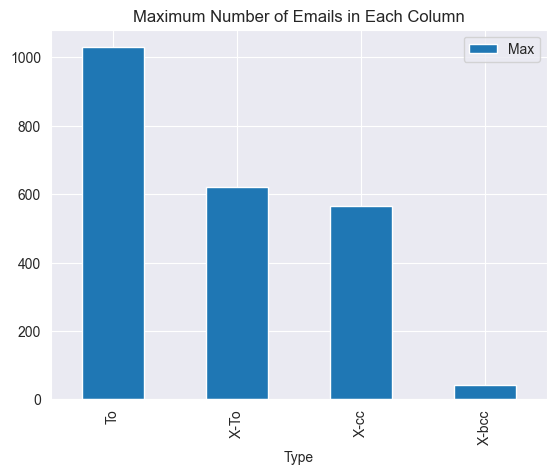

In [6]:
emails_df = pd.DataFrame({
    'Type': ['To', 'X-To', 'X-cc', 'X-bcc'],
    'Max': [max_emails_column1[0], max_emails_column2[0], max_emails_column3[0], max_emails_column4[0]],
    # 'Min': [max_emails_column1[1], max_emails_column2[1], max_emails_column3[1], max_emails_column4[1]]
})

emails_df.plot(x='Type', y=['Max'], kind='bar', title='Maximum Number of Emails in Each Column')

We want to see the total number of violated data

In [7]:
# check sum of violated rules
violated_rule_11 = enron_df['violated_rules'].str.contains('1.1', na=False).sum()
violated_rule_12 = enron_df['violated_rules'].str.contains('1.2', na=False).sum()
violated_rule_13 = enron_df['violated_rules'].str.contains('1.3', na=False).sum()
violated_rule_21 = enron_df['violated_rules'].str.contains('2.1', na=False).sum()
violated_rule_22 = enron_df['violated_rules'].str.contains('2.2', na=False).sum()
violated_rule_23 = enron_df['violated_rules'].str.contains('2.3', na=False).sum()

print(f"Number of emails violating rule 1.1: {violated_rule_11}")
print(f"Number of emails violating rule 1.2: {violated_rule_12}")
print(f"Number of emails violating rule 1.3: {violated_rule_13}")

print(f"Number of emails violating rule 2.1: {violated_rule_21}")
print(f"Number of emails violating rule 2.2: {violated_rule_22}")
print(f"Number of emails violating rule 2.3: {violated_rule_23}")

print(f"Total number of emails violating rules: {violated_rule_11 + violated_rule_12 + violated_rule_13 + violated_rule_21 + violated_rule_22 + violated_rule_23}")



Number of emails violating rule 1.1: 443
Number of emails violating rule 1.2: 1987
Number of emails violating rule 1.3: 30632
Number of emails violating rule 2.1: 9097
Number of emails violating rule 2.2: 9783
Number of emails violating rule 2.3: 18736
Total number of emails violating rules: 70678


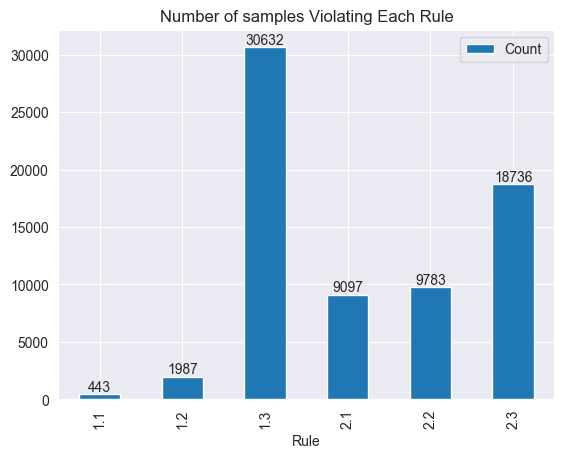

In [8]:
# plot the number of samples violating each rule
violated_rules_df = pd.DataFrame({
    'Rule': ['1.1', '1.2', '1.3', '2.1', '2.2', '2.3'],
    'Count': [violated_rule_11, violated_rule_12, violated_rule_13, violated_rule_21, violated_rule_22, violated_rule_23]
})

ax = violated_rules_df.plot.bar(x='Rule', y='Count', title='Number of samples Violating Each Rule')
for container in ax.containers:
    ax.bar_label(container)

In [9]:
# check multiple violations, 1.2 with 2.1, 1.3 with 2.2, 1.3 with 2.1 and 2.2
violated_rule_12_21 = enron_df[(enron_df['violated_rules'].str.contains('1.2', na=False)) & (enron_df['violated_rules'].str.contains('2.1', na=False))].shape[0]
violated_rule_13_22 = enron_df[(enron_df['violated_rules'].str.contains('1.3', na=False)) & (enron_df['violated_rules'].str.contains('2.2', na=False))].shape[0]
violated_rule_13_21_22 = enron_df[(enron_df['violated_rules'].str.contains('1.3', na=False)) & (enron_df['violated_rules'].str.contains('2.1', na=False)) & (enron_df['violated_rules'].str.contains('2.2', na=False))].shape[0]

print(f"Number of emails violating rules 1.2 and 2.1: {violated_rule_12_21}")
print(f"Number of emails violating rules 1.3 and 2.2: {violated_rule_13_22}")
print(f"Number of emails violating rules 1.3, 2.1 and 2.2: {violated_rule_13_21_22}")

# check for all violations with 1.* and 2.3
violated_rule_1_all = enron_df[(enron_df['violated_rules'].str.contains('1.', na=False)) & (enron_df['violated_rules'].str.contains('2.3', na=False))].shape[0]

print(f"Number of emails violating all rules 1.* and 2.3: {violated_rule_1_all}")

Number of emails violating rules 1.2 and 2.1: 1671
Number of emails violating rules 1.3 and 2.2: 2094
Number of emails violating rules 1.3, 2.1 and 2.2: 64
Number of emails violating all rules 1.* and 2.3: 9244


We want to get all mails and the corresponding departments for them

In [10]:
def extract_sent_to_emails(text):
    emails = extract_emails(text)
    if len(emails) > 0:
        return emails
    return []

enron_df['total_mails'] = enron_df['To'].apply(extract_sent_to_emails) + enron_df['X-To'].apply(extract_sent_to_emails) + enron_df['X-cc'].apply(extract_sent_to_emails) + enron_df['X-bcc'].apply(extract_sent_to_emails) + enron_df['From'].apply(extract_sent_to_emails) + enron_df['X-From'].apply(extract_sent_to_emails) 
enron_df['total_mails'] = enron_df['total_mails'].apply(lambda x: set(x))
all_mails = enron_df['total_mails'].agg(lambda x: set.union(*x))
# drop the column total_mails
enron_df.drop(columns=['total_mails'], inplace=True)
print(f"Total number of unique emails: {len(all_mails)}")


Total number of unique emails: 124600


In [11]:
# Total unique emails from 'From' column in ernon_df
def extract_single_email_from_text(text):
    emails = extract_emails(text)
    if (len(emails) > 1):
        print(f"Multiple emails found in: {text}")
    elif len(emails) == 1:
        return emails[0]
    print(f"Could not extract email from: {text}")
    return None

unique_emails_from = enron_df['From'].apply(extract_single_email_from_text).nunique()
print(f"Total unique emails in 'X-From': {unique_emails_from}")

Could not extract email from: u@d.h
Could not extract email from: pep <performance.>
Total unique emails in 'X-From': 20306


In [12]:
# extract company departments from X-From and X-To and X-cc and X-bcc
email_to_departments = {}

multiple_count = 0
# TODO: implement check for multiple emails in X-From and From. should be only one email
for index, row in enron_df.iterrows():
    x_emails = extract_emails(row['X-From'])
    emails = set([mail.lower() for mail in (extract_emails(row['From']) + x_emails)])
    if len(emails) == 0:
        continue
    if len(emails) > 1:
        emails = [mail for mail in emails if not mail.startswith('imceanotes')]
        if len(emails) > 1 or len(emails) == 0:
            # print(f"From: {row['From']} X-From: {row['X-From']} has multiple emails: {emails}")
            multiple_count += 1

    for email in emails:
        email = email.lower()
        # TODO: validate company email starts with enron.com
        if "enron.com" not in email:
            email_to_departments.update({email: 'NA'})
        else:
            if email in email_to_departments and email_to_departments[email] != 'Other':
                continue
            if 'EES' in row['X-From']:
                email_to_departments.update({email: 'EES'})
            elif 'ECT' in row['X-From']:
                email_to_departments.update({email: 'ECT'})
            else:
                email_to_departments.update({email: 'Other'})


email_to_departments.update({'eric.bass@enron.com': 'ECT'})

# print multiple count
print(f"multiple count {multiple_count}")


# extract emails from X-From, X-To, X-cc, X-bcc where the email is not from enron.com
def get_all_outside_mail(mails):
    return [mail for mail in mails if 'enron.com' not in mail.lower()]

all_outside_emails = get_all_outside_mail(all_mails)
print(f"Total number of emails outside enron.com: {len(all_outside_emails)}")

counter = 0
for email in all_outside_emails:
    if email not in email_to_departments:
        email_to_departments.update({email: 'NA'})
    # elif email_to_departments[email] != 'Other':
        # print(f"Email: {email} is from EES or ECT")
        # counter += 1
    # else:
        # print(f"Email: {email} already exists in email_to_departments and is from Other department")

print(f"Total number of emails outside enron.com with departments: {len(all_outside_emails) - counter}")


counter = {}
for key, value in email_to_departments.items():
    if value in counter:
        counter[value] += 1
    else:
        counter[value] = 1

# print dictionary
for key, value in counter.items():
    print(key, value)

multiple count 432
Total number of emails outside enron.com: 86745
Total number of emails outside enron.com with departments: 86745
ECT 310
NA 86805
Other 6102
EES 72


In [13]:
ect_mails = enron_df[enron_df['violated_rules'].str.contains('2.1', na=False)]
ect_mails = ect_mails['From'] + ect_mails['X-From']
ect_mails = ect_mails.apply(extract_sent_to_emails)
ect_mails = ect_mails.apply(lambda x: set(x))
ect_mails = set.union(*ect_mails)

print(f"Number of unique emails in ECT: {len(ect_mails)}")
for email in ect_mails:
    if email not in email_to_departments:
        email_to_departments.update({email: 'ECT'})

Number of unique emails in ECT: 754


In [14]:
enron_df['From_department'] = enron_df['From'].apply(lambda x: email_to_departments[extract_single_email_from_text(x)] if extract_single_email_from_text(x) in email_to_departments else 'Other')

Could not extract email from: u@d.h
Could not extract email from: pep <performance.>


In [15]:
def get_department(emails, wanted_Department):
    for email in emails:
        if email in email_to_departments:
            if email_to_departments[email] == wanted_Department:
                return True
    return False

enron_df['sent_to'] = enron_df['To'].apply(extract_sent_to_emails) + enron_df['X-To'].apply(extract_sent_to_emails) + enron_df['X-cc'].apply(extract_sent_to_emails) + enron_df['X-bcc'].apply(extract_sent_to_emails)
enron_df['To_EES'] = enron_df['sent_to'].apply(lambda x: get_department(x, 'EES'))
enron_df['To_ECT'] = enron_df['sent_to'].apply(lambda x: get_department(x, 'ECT'))


In [16]:
enron_df['email_text'] = enron_df['Subject'] + ' ' + enron_df['email_body']

In [17]:
from gensim import corpora, models, similarities
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
import nltk

want_to_check = False

if want_to_check:
    # Ensuring necessary nltk resources are available
    nltk.download('wordnet')

    model_path = 'lda_model.gensim'

    lemmatizer = WordNetLemmatizer()

    # Text preprocessing function
    def preprocess_text(document:str):
        return [lemmatizer.lemmatize(word) for word in document.lower().split() if word not in STOPWORDS and word.isalpha()]

    # Preprocessed documents
    texts = enron_df['email_text'].apply(preprocess_text)

    # # Step 2: Prepare a dictionary and corpus
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    if os.path.exists(model_path):
        print("Model found")
        lda_model = models.LdaModel.load(model_path)
    else:
        print("Model not found")
        # Apply LDA model
        lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)




ImportError: cannot import name 'triu' from 'scipy.linalg' (/Users/maore/Documents/Reichman/Cyber AI/HW/cyber-ai/venv/lib/python3.12/site-packages/scipy/linalg/__init__.py)

In [ ]:
lda_model.save('lda_model.gensim')

In [ ]:
# # Step 4: Print the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

# # Step 5: Apply the LDA model to the corpus
lda_corpus = lda_model[corpus]

# # Step 6: Extract the topics
lda_topics = [max(probabilities, key=lambda x: x[1])[0] for probabilities in lda_corpus]


In [ ]:
# Assign the most dominant topic to each document
dominant_topics = []
for i, row_list in enumerate(lda_model[corpus]):
    row = row_list[0] if lda_model.per_word_topics else row_list            
    # Sort with the most highly related topics first
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the dominant topic, its percentage contribution, and keywords for each document
    # for j, (topic_num, prop_topic) in enumerate(row):
    #     if j == 0:  # => dominant topic
    #         dominant_topics.append((i, topic_num, prop_topic))
    if row and row[0][0] in {0, 1}:  # Check if the dominant topic is 0 or 1
        dominant_topics.append((i, row[0][0], row[0][1]))  # doc index, topic number, and weight


# Get the top words for each topic (example: top 10 words)
for topic_id in range(lda_model.num_topics):
    words = lda_model.show_topic(topic_id, 10)
    print(f"Topic {topic_id}: {[word for word, prob in words]}")

topic_to_label_map = {
    0: '1.2',
    1: '1.1',
    # 2: 'None',
    # 3: 'label_for_topic_3',
    # 4: 'label_for_topic_4'
    # continue mapping based on your topics and labels
}

actual_labels = enron_df['violated_rules'].tolist()

# Extract labels from the dataframe, but only for the filtered documents
filtered_labels = [enron_df.iloc[idx]['violated_rules'] for idx, topic_num, _ in dominant_topics]

# Map topics to your labels based on the dominant topic for each document
mapped_labels = [topic_to_label_map[topic_num] for _, topic_num, _ in dominant_topics]

# Calculate accuracy
accuracy = sum(1 for actual, predicted in zip(filtered_labels, mapped_labels) if actual in predicted) / len(filtered_labels)
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report


labels = [ 'legal', 'business', 'financial', 'business or financial', 'other']

def rule_to_label(rule):
    if '1.1' in rule:
        return 'legal'
    elif '1.2' in rule:
        return 'financial'
    elif '1.3' in rule:
        return 'business or financial'
    return 'other'

enron_df['label'] = enron_df['violated_rules'].apply(rule_to_label)


In [ ]:
filtered = enron_df[enron_df['violated_rules'].str.contains('1.1', na=False)]

# plot the filtered pd dataframe with the count of EES and ECT
# filtered.plot.scatter(x='EES_count', y='ECT_count', title='Count of EES vs. ECT in Violated Emails')
not_filtered = enron_df[~enron_df['violated_rules'].str.contains('1.1', na=False)]

# plot the not filtered pd dataframe with the count of EES and ECT
# not_filtered.plot.scatter(x='EES_count', y='ECT_count', title='Count of EES vs. ECT in Non-violated Emails')

filtered.head(10)

print(filtered.shape)
filtered_ees_ect = filtered[(filtered['ECT_count'] == 0) & (filtered['EES_count'] == 0)]
print(filtered_ees_ect.shape)
filtered.head(10)


In [ ]:

# TODO: need to check if we need to drop rows with null values in 'To' column.
def count_nulls(df, columns):
    """Print the number of nulls in specified columns of a dataframe."""
    for column in columns:
        null_count = df[column].isnull().sum()
        print(f"Number of rows with null values in '{column}': {null_count}")

def drop_nulls(df, columns):
    """Drop rows from the dataframe where specified columns have null values."""
    before_drop = df.shape[0]
    df.dropna(subset=columns, inplace=True)
    after_drop = df.shape[0]
    print(f"Dropped {before_drop - after_drop} rows. Remaining rows: {after_drop}")

def apply_lower_case(df, columns):
    """Convert the contents of specified columns in the dataframe to lower case."""
    for column in columns:
        df[column] = df[column].str.lower()

# replace empty missing value in subject with np.nan
def replace_empty_with_nan(subject):
    column=[]
    for sub in subject:
        if sub=="":
            column.append(np.nan)
        else:
            column.append(sub)
    return column


def process_dataframe(df):
    # Identify columns to check for nulls and to convert to lower case inplace!
    columns_to_check = ['From', 'To']
    email_related_columns = ['From', 'To', 'X-From', 'X-To', 'X-cc', 'X-bcc']

    # Null removal process
    count_nulls(df, columns_to_check)
    drop_nulls(df, columns_to_check)
    
    # Convert email related columns to lower case (email is case insensitive)
    apply_lower_case(df, email_related_columns)
    

In [ ]:
from datetime import datetime
from dateutil import parser

def parse_date(date_str):
    # Parse the datetime string including timezone using dateutil.parser
    dt = parser.parse(date_str)
    
    # Extract components
    day_of_week = dt.strftime('%A')
    day = dt.day
    month = dt.month
    year = dt.year
    time_in_minutes = (dt.hour * 60 + dt.minute) / 1440  # Convert time to minutes and normalize
    timezone = dt.tzname()  # Gets the timezone name
    
    return day_of_week, day, month, year, time_in_minutes, timezone


def get_email_type(text):
    """
    Function to determine the type of email based on the subject line.
    Forwarded emails start with 'Fo', replies start with 'Re', and other emails are 'Normal'.
    """
    if text.startswith('Fo') or text.startswith('Re') or text.startswith('FW'):
        return text[:2]
    else:
        return 'Normal'

def split_email_addresses(line):
    """
    Function to split email addresses in the 'From' and 'To' columns.
    The email addresses are separated by commas.
    TODO: need to add regex to extract email addresses from the text.
    """

    if line:
        addrs = line.split(',')
        for i, addr in enumerate(addrs):
            # Remove any names in the email addresses
            if '<' in addr:
                pass
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs



def transform_dataframe(df, split_date=True):
    # transform the 'Date' column to extract day of week, day, month, year, time in minutes, and timezone
    if split_date:
        df['day_of_week'], df['day'], df['month'], df['year'], df['time_in_minutes'], df['timezone'] = zip(*df['Date'].apply(parse_date))
        df.drop(columns=['Date'], inplace=True)

    # add a new column 'email_type' to the dataframe, which represents the type of email (Foward, Reply, Normal)
    df['email_type'] = df['Subject'].apply(get_email_type)

        
    df['From'] = df['From'].map(split_email_addresses)
    df['To'] = df['To'].map(split_email_addresses)
    
    return df

In [ ]:
process_dataframe(enron_df)
transform_dataframe(enron_df, split_date=False)

enron_df.head(10)

ADL performence

In [ ]:
user_to_place = {}
user_to_role = {}

def add_user_to_role(email, role):
    user_to_role[email] = role

def add_user_to_place(email, place):
    user_to_place[email] = place

def extract_custom_format(text):
    # Regular expression pattern to capture structured tags
    pattern = r'<o=([^/]+)/ou=([^/]+)/cn=([^/]+)/cn=([^>]+)>'
    match = re.search(pattern, text)
    if match:
        # Extracting each group as a separate part
        return {
            'organization': match.group(1),
            'unit': match.group(2),
            'container1': match.group(3),
            'container2': match.group(4)
        }
    return None


for row in enron_df:
    from_email = row['From']
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    # Finding all substrings that match the pattern
    emails = re.findall(email_pattern, from_email)
    if len(emails) == 1:
        pass

In [ ]:
def is_between_ect_and_ees(row):
    sender_email = extract_single_email_from_text(row['From'])
    if sender_email in email_to_departments:
        sender_department = email_to_departments[sender_email]
        if sender_department != 'ECT' and sender_department != 'EES':
            return False
        else:
            reciever_emails = extract_sent_to_emails(row['To']) + extract_sent_to_emails(row['X-To']) + extract_sent_to_emails(row['X-cc']) + extract_sent_to_emails(row['X-bcc'])
            for email in reciever_emails:
                if email in email_to_departments:
                    reciever_department = email_to_departments[email]

                    if sender_department == 'ECT' and reciever_department == 'EES':
                        return True
                    elif sender_department == 'EES' and reciever_department == 'ECT':
                        return True
    else:
        return False


def is_between_EU_US(row):
    pass

def is_outside_ECT(row):
    pass

def is_sending_outside_corp(row):
    reciever_emails = extract_sent_to_emails(row['To']) + extract_sent_to_emails(row['X-To']) + extract_sent_to_emails(row['X-cc']) + extract_sent_to_emails(row['X-bcc'])
    reciever_emails = set(mail.lower() for mail in reciever_emails)
    for email in reciever_emails:
        if "@enron.com" not in email:
            return True
    return False


# test = enron_df.apply(is_sending_outside_corp, axis=1)
# # print(test.value_counts())

# test_with_correct = enron_df[enron_df['violated_rules'].str.contains('2.3', na=False)]

# test_with_correct['is_outside'] = test_with_correct.apply(is_sending_outside_corp, axis=1)

# # print(test_with_correct.value_counts())
# pd.set_option('display.max_colwidth', 255)
# test_with_correct[test_with_correct['is_outside'] == False].head(10)


In [ ]:
# # ADL
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation

# ADL_data = enron_df[['email_body', 'violated_rules']].copy()

# filtered_data = ADL_data.dropna()
# ADL_data.head(10)


# # Text preprocessing and vectorization
# vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
# dtm = vectorizer.fit_transform(filtered_data['email_body'])  # Document-term matrix


# n_topics = 3  # You can choose this number based on unique labels or other criteria
# lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
# lda.fit(dtm)

# # Display the topics found by the LDA model
# def display_topics(model, feature_names, no_top_words):
#     for topic_idx, topic in enumerate(model.components_):
#         print("Topic %d:" % (topic_idx))
#         print(" ".join([feature_names[i]
#                         for i in topic.argsort()[:-no_top_words - 1:-1]]))

# no_top_words = 5
# display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)
